In [1]:
import xarray as xr
import polars as pl
import glob
import pandas as pd
import re
from datetime import datetime
import os
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np
from utils import reading as rd

In [2]:
glider_a = "Churchill"
glider_b = "Nelson"

In [3]:

# Get list of NetCDF files
nc_files = glob.glob("C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled/*.nc")

# Read and concatenate datasets
for file in nc_files:
    df_pl = rd.read_glider_og1(file, to_polars=True)

    #Use only profiling data (-1 is surfacing behavior)
    df_pl = df_pl.filter(pl.col("PROFILE_NUMBER") > 0)

    #create a profile id column. The profile id differs from the profile number, as it includes the glider name, hence it is unique.
    df_pl = df_pl.with_columns((pl.col("PROFILE_NUMBER").cast(pl.String) + "_" + pl.col("glider_name")).alias("profile_id"))
    print(f"{file} processed, shape: {df_pl.shape}")

    # Concatenate DataFrames
    if 'df_concat' in locals():
        df_concat = pl.concat([df_concat, df_pl])
    else:
        df_concat = df_pl

C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Cabot_645_Profiled.nc processed, shape: (1438541, 13)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Churchill_647_Profiled.nc processed, shape: (1142019, 13)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Doombar_648_Profiled.nc processed, shape: (1952630, 13)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Nelson_646_Profiled.nc processed, shape: (1951435, 13)


In [4]:
glider_a_df = df_concat.filter(pl.col("glider_name") == glider_a)
glider_b_df = df_concat.filter(pl.col("glider_name") == glider_b)

In [5]:
# Group by 'profile_id' and 'glider_name', then aggregate median datetime, longitude, latitude
summary = (
    glider_a_df
    .group_by(['profile_id', 'glider_name'])
    .agg([
        pl.col('TIME').median().alias('median_datetime'),
        pl.col('LONGITUDE').median().alias('median_longitude'),
        pl.col('LATITUDE').median().alias('median_latitude')
    ])
    .sort('median_datetime')
)

# Convert to pandas DataFrame for easier display if needed
summary_glider_a = summary.to_pandas()
summary_glider_a.head()

,profile_id,glider_name,median_datetime,median_longitude,median_latitude
0,1.0_Churchill,Churchill,2024-05-28 18:28:44.618514688,-23.969954,59.958019
1,2.0_Churchill,Churchill,2024-05-28 18:33:09.395462656,-23.969658,59.958664
2,3.0_Churchill,Churchill,2024-05-28 19:03:39.730010624,-23.966108,59.959362
3,4.0_Churchill,Churchill,2024-05-28 19:16:50.620117248,-23.964430,59.961582
4,5.0_Churchill,Churchill,2024-05-28 19:46:33.447570432,-23.963081,59.963272


In [6]:
# Create a summary table from combined_df with one line per profile (grouped by 'datetime', 'lon', 'lat')
summary_glider_b = (
    glider_b_df
    .group_by(['profile_id', 'glider_name'])
    .agg([
        pl.col('TIME').median().alias('median_datetime'),
        pl.col('LONGITUDE').median().alias('median_longitude'),
        pl.col('LATITUDE').median().alias('median_latitude')
    ])
    .sort('median_datetime')
)

summary_glider_b = summary_glider_b.to_pandas()

In [7]:
# Prepare arrays for glider and CTD profile locations and times
glider_a_times = summary_glider_a['median_datetime'].values
glider_a_lons = summary_glider_a['median_longitude'].values
glider_a_lats = summary_glider_a['median_latitude'].values

glider_b_times = summary_glider_b['median_datetime'].values
glider_b_lons = summary_glider_b['median_longitude'].values
glider_b_lats = summary_glider_b['median_latitude'].values
glider_b_profile_ids = summary_glider_b['profile_id'].values
# For each glider profile, find the closest CTD profile in time and compute distance
closest_glider_b_profile = []
closest_time_diff = []
distance_km = []

for g_time, g_lat, g_lon in zip(glider_a_times, glider_a_lats, glider_a_lons):
    # Find index of closest CTD profile in time
    time_diffs = abs(glider_b_times - g_time)
    idx = time_diffs.argmin()
    closest_glider_b_profile.append(glider_b_profile_ids[idx])
    closest_time_diff.append(time_diffs[idx])
    # Compute distance in km, handle nan coordinates
    glider_pos = (g_lat, g_lon)
    b_pos = (glider_b_lats[idx], glider_b_lons[idx])
    if np.isfinite(g_lat) and np.isfinite(g_lon) and np.isfinite(glider_b_lats[idx]) and np.isfinite(glider_b_lons[idx]):
        dist = geodesic(glider_pos, b_pos).km
    else:
        dist = np.nan
    distance_km.append(dist)

# Add results to summary_pd
summary_glider_a['closest_glider_b_profile'] = closest_glider_b_profile
summary_glider_a['glider_b_time_diff'] = closest_time_diff
summary_glider_a['glider_b_distance_km'] = distance_km

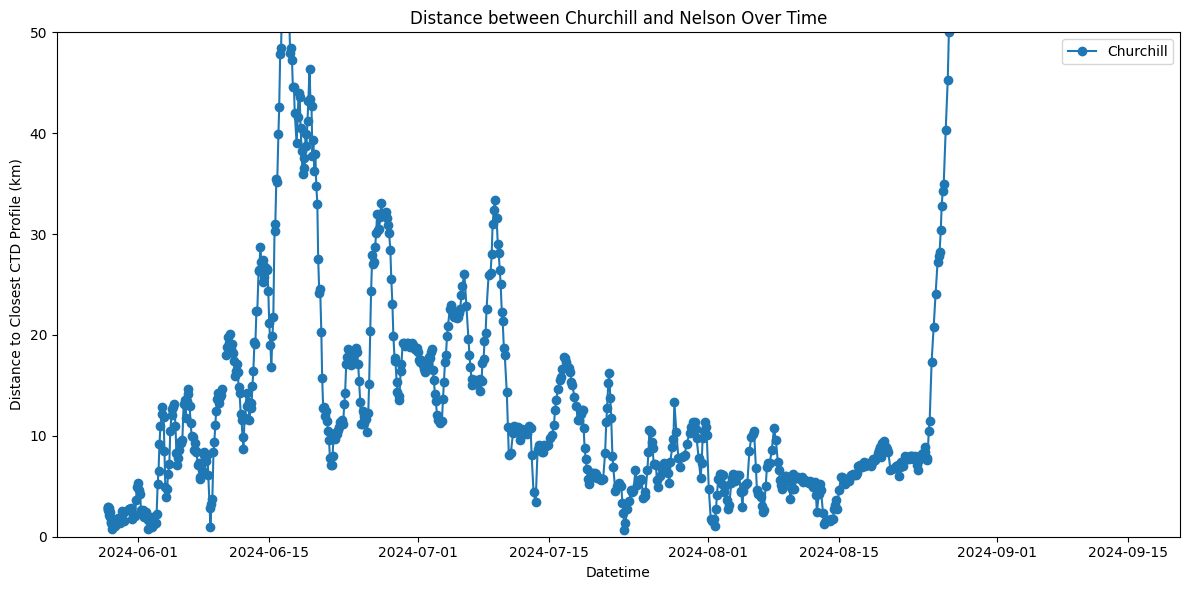

In [8]:
# Get the last CTD profile datetime
last_glider_time = glider_a_times[-1]

# Filter summary_pd to only include glider profiles up to the last CTD profile datetime
mask = summary_glider_a['median_datetime'] <= last_glider_time
filtered = summary_glider_a[mask]

# Plot
plt.figure(figsize=(12, 6))
for name, group in filtered.groupby('glider_name'):
    plt.plot(group['median_datetime'], group['glider_b_distance_km'], label=name, marker='o', linestyle='-')

plt.xlabel('Datetime')
plt.ylabel('Distance to Closest CTD Profile (km)')
plt.ylim(0, 50)
plt.title(f'Distance between {glider_a} and {glider_b} Over Time')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from geopy.distance import geodesic

def find_candidate_glider_pairs(glider_a_df, glider_b_df, time_thresh_hr=2, dist_thresh_km=5):
    """
    Identify all pairs of glider and CTD profiles within specified time (hours) and distance (km) thresholds.
    
    Returns a DataFrame of matching pairs with details.
    """
    matches = []
    
    for _, g_row in glider_a_df.iterrows():
        for _, c_row in glider_b_df.iterrows():
            # Time difference
            time_diff_hr = abs((g_row['median_datetime'] - c_row['median_datetime']).total_seconds()) / 3600.0
            if time_diff_hr > time_thresh_hr:
                continue

            # Skip if coordinates are missing
            if pd.isnull(g_row['median_latitude']) or pd.isnull(g_row['median_longitude']) \
               or pd.isnull(c_row['median_latitude']) or pd.isnull(c_row['median_longitude']):
                continue

            # Distance in kilometers
            dist_km = geodesic(
                (g_row['median_latitude'], g_row['median_longitude']),
                (c_row['median_latitude'], c_row['median_longitude'])
            ).km

            if dist_km > dist_thresh_km:
                continue

            matches.append({
                'glider_a_profile_id': g_row['profile_id'],
                'glider_name': glider_a,
                'glider_b_profile_id': c_row.get('profile_id', None),  # default to None if not present
                'glider_b_name': glider_b,
                'time_diff_hr': time_diff_hr,
                'dist_km': dist_km
            })
    
    return pd.DataFrame(matches)

In [10]:
from utils.matchup import find_candidate_profile_pairs
candidates = find_candidate_profile_pairs(
    summary_glider_a, summary_glider_b,
    datetime_col1='median_datetime', lat_col1='median_latitude', lon_col1='median_longitude',
    datetime_col2='median_datetime', lat_col2='median_latitude', lon_col2='median_longitude',
    id_col1='profile_id', id_col2='profile_id',
    name_col1='glider_name', name_col2='glider_name',
    time_thresh_hr=12, dist_thresh_km=20,
    label1='glider_a', label2='glider_b'
)

In [11]:
def plot_heatmap_glider_df(glider_matchup_df, time_bins, dist_bins):
    """
    Plot cumulative 2D histogram (heatmap) of matchups from a DataFrame for a specific glider.
    
    Parameters:
    - glider_name: str, the glider to filter
    - df: pd.DataFrame with required columns: 
          'glider_profile_id', 'glider_name', 'ctd_profile_id', 'time_diff_hr', 'dist_km'
    - time_bins: array-like, bin edges for time (in hours)
    - dist_bins: array-like, bin edges for distance (in km)
    """

    # Filter DataFrame for selected glider

    if glider_matchup_df.empty:
        print(f"No matchups found for glider '{glider_name}'.")
        return

    # Extract arrays for histogram
    time_diffs = glider_matchup_df['time_diff_hr'].values
    dist_kms = glider_matchup_df['dist_km'].values

    # Compute 2D histogram
    H, xedges, yedges = np.histogram2d(time_diffs, dist_kms, bins=[time_bins, dist_bins])

    # Cumulative sum along both axes
    H_cum = H.cumsum(axis=0).cumsum(axis=1)

    # Plot heatmap
    X, Y = np.meshgrid(yedges, xedges)
    plt.figure(figsize=(9, 7))
    plt.pcolormesh(X, Y, H_cum, cmap='PuBu', shading='auto')
    plt.colorbar(label='Cumulative Number of Matchups')
    plt.xlabel('Distance Threshold (km)')
    plt.ylabel('Time Threshold (hr)')
    plt.title(f'Cumulative Matchups by Time/Distance\nGlider: {glider_a} VS {glider_b}')

    # Annotate each cell with value
    for i in range(H_cum.shape[0]):
        for j in range(H_cum.shape[1]):
            val = int(H_cum[i, j])
            if val > 0:
                x_center = (yedges[j] + yedges[j+1]) / 2
                y_center = (xedges[i] + xedges[i+1]) / 2
                color = 'white' if val > H_cum.max() / 2 else 'black'
                plt.text(x_center, y_center, str(val), ha='center', va='center', fontsize=8, color=color)

    plt.tight_layout()
    plt.show()

In [12]:
#Filter the pairs of profiles to keep only unique glider_b profiles. By doing so we have a more accurate representation of independent matchups. 
filtered_candidates = candidates.loc[
    candidates.groupby('glider_b_profile_id')['dist_km'].idxmin()
].reset_index(drop=True)

filtered_candidates.head()

,glider_a_profile_id,glider_b_profile_id,time_diff_hr,dist_km,glider_a_name,glider_b_name
0,1.0_Churchill,1.0_Nelson,2.303247,2.853364,Churchill,Nelson
1,3.0_Churchill,10.0_Nelson,1.037154,2.160987,Churchill,Nelson
2,111.0_Churchill,100.0_Nelson,8.794930,3.785061,Churchill,Nelson
3,679.0_Churchill,1000.0_Nelson,8.718839,2.841271,Churchill,Nelson
4,679.0_Churchill,1001.0_Nelson,7.211476,3.824582,Churchill,Nelson


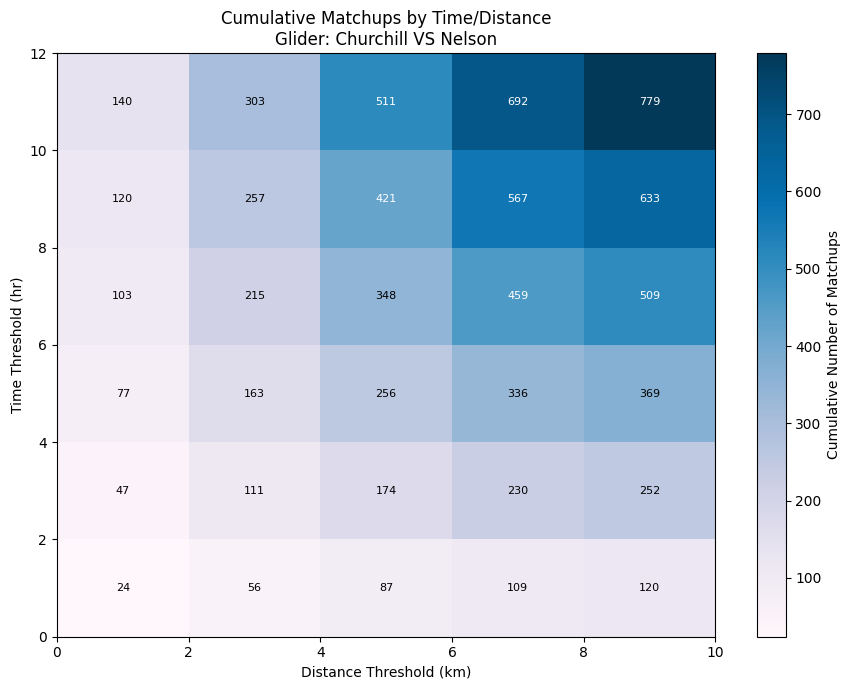

In [13]:
time_bins = np.arange(0, 13, 2) 
dist_bins = np.arange(0, 11, 2)

plot_heatmap_glider_df(filtered_candidates, time_bins, dist_bins)

In [14]:
# Interpolate DEPTH values per profile_id in df_concat (polars DataFrame)
# We'll use group_by and apply interpolation using polars' .interpolate() method

glider_a_df = (
    glider_a_df
    .sort(['profile_id', 'TIME'])
    .with_columns([
        pl.col('DEPTH')
        .interpolate()
        .over('profile_id')
        .alias('DEPTH_interp')
    ])
)

glider_b_df = (
    glider_b_df
    .sort(['profile_id', 'TIME'])
    .with_columns([
        pl.col('DEPTH')
        .interpolate()
        .over('profile_id')
        .alias('DEPTH_interp')
    ])
)

In [15]:
# Add a 'depth_bin' column to df_concat, binning 'DEPTH' in 50m intervals
glider_a_df = glider_a_df.with_columns(
    (-(pl.col("DEPTH_interp") // 5)).cast(pl.Int32).alias("depth_bin"))
# Add a 'depth_bin' column to combined_df, binning 'CTDPRS' in 50m intervals

glider_b_df = glider_b_df.with_columns(
    (-(pl.col("DEPTH_interp") // 5)).cast(pl.Int32).alias("depth_bin"))

In [16]:
# Group by 'profile_id', 'glider_name', and 'depth_bin', then aggregate median for selected variables
glider_a_binned = (
    glider_a_df
    .group_by(['profile_id', 'glider_name', 'depth_bin'])
    .agg([
        pl.col('TEMP').median().alias('median_temp'),
        pl.col('ABS_SALINITY').median().alias('median_salinity'),
        pl.col('CHLA').median().alias('median_chla'),
        pl.col('BBP700').median().alias('median_bbp'),
        pl.col('MOLAR_DOXY').median().alias('median_doxy')
    ])
    .sort(['profile_id', 'depth_bin'])
)
# Remove rows with any missing values in the aggregated table
glider_a_binned = glider_a_binned.drop_nulls()

# Group by 'profile_id', 'glider_name', and 'depth_bin', then aggregate median for selected variables
glider_b_binned = (
    glider_b_df
    .group_by(['profile_id', 'glider_name', 'depth_bin'])
    .agg([
        pl.col('TEMP').median().alias('median_temp'),
        pl.col('ABS_SALINITY').median().alias('median_salinity'),
        pl.col('CHLA').median().alias('median_chla'),
        pl.col('BBP700').median().alias('median_bbp'),
        pl.col('MOLAR_DOXY').median().alias('median_doxy')
    ])
    .sort(['profile_id', 'depth_bin'])
)
# Remove rows with any missing values in the aggregated table
glider_b_binned = glider_b_binned.drop_nulls()

In [18]:
# Convert candidates to polars DataFrame
candidates_pl = pl.from_pandas(candidates)
# Remove 'glider_name' and 'glider_b_name' columns from candidates_pl
candidates_pl = candidates_pl.drop(['glider_a_name', 'glider_b_name'])
# Join all depth bins for each glider_profile_id from glider_binned
# This will add all depth-bin data for each candidate glider profile
candidates_with_bins = candidates_pl.join(
    glider_a_binned,
    left_on="glider_a_profile_id",
    right_on="profile_id",
    how="left",
    suffix="_a"
)


In [19]:
# Ensure column names and data types match before joining
candidates_with_bins = candidates_with_bins.join(
        glider_b_binned,
        left_on=["glider_b_profile_id", "depth_bin"],
        right_on=["profile_id", "depth_bin"],
        how="left",
        suffix="_b")

In [20]:
candidates_with_bins = candidates_with_bins.filter(pl.col("median_chla").is_not_null())

In [21]:
def type2_regression_r2_pybroom(x, y):
    """
    Compute R2 for type 2 regression (major axis regression) using pybroom.
    """
    # Remove NaNs
    mask = np.isfinite(x) & np.isfinite(y)
    x_clean = x[mask]
    y_clean = y[mask]
    
    if len(x_clean) < 2:
        return np.nan
    
    # Type 2 regression slope
    s_yx = np.std(y_clean, ddof=1) / np.std(x_clean, ddof=1)
    r = np.corrcoef(x_clean, y_clean)[0, 1]
    slope = np.sign(r) * s_yx
    intercept = np.mean(y_clean) - slope * np.mean(x_clean)
    
    # Create a simple linear model for pybroom compatibility
    # We'll use the type 2 regression parameters we calculated
    y_pred = slope * x_clean + intercept
    
    # Calculate R2
    ss_res = np.sum((y_clean - y_pred) ** 2)
    ss_tot = np.sum((y_clean - np.mean(y_clean)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    
    return r2




In [22]:
# Updated analysis using pybroom concepts
# Group the final_matched DataFrame by 'glider_profile_id' and 'ctd_profile_id'
grouped = candidates_with_bins.to_pandas().groupby(['glider_a_profile_id', 'glider_b_profile_id'])

var_list = ["temp", "salinity", "chla", "bbp", "doxy"]

results = []
for keys, group in grouped:
    row = {'glider_a_profile_id': keys[0], 'glider_b_profile_id': keys[1]}
    # Add time and distance from the first row in group
    first_row = group.iloc[0]
    row['time_diff_hr'] = first_row['time_diff_hr']
    row['dist_km'] = first_row['dist_km']
    
    for var in var_list:
        out_col = f"r2_{var}"
        var_a = f"median_{var}"
        var_b = f"median_{var}_b"
        x = group[var_a].to_numpy()
        y = group[var_b].to_numpy()
        row[out_col] = type2_regression_r2_pybroom(x, y)
    results.append(row)

# Convert to DataFrame
r2_df = pd.DataFrame(results)


c:\Users\flapet\OneDrive - NOC\Documents\risc_glider_demo\risc_env\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\flapet\OneDrive - NOC\Documents\risc_glider_demo\risc_env\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\flapet\AppData\Local\Temp\ipykernel_28228\4172637948.py:14: RuntimeWarning: invalid value encountered in scalar divide
  s_yx = np.std(y_clean, ddof=1) / np.std(x_clean, ddof=1)
C:\Users\flapet\AppData\Local\Temp\ipykernel_28228\4172637948.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  s_yx = np.std(y_clean, ddof=1) / np.std(x_clean, ddof=1)


In [23]:
# Filter out rows with NaN values in the 'temp_r2' column
filtered_r2_df = r2_df.dropna(subset=['r2_temp'])

if not filtered_r2_df.empty:
	filtered_r2_df = filtered_r2_df.loc[filtered_r2_df.groupby('glider_a_profile_id')['r2_temp'].idxmax()].reset_index(drop=True)
else:
	filtered_r2_df = pd.DataFrame()  # Return an empty DataFrame if no valid rows remain

filtered_r2_df.head()

,glider_a_profile_id,glider_b_profile_id,time_diff_hr,dist_km,r2_temp,r2_salinity,r2_chla,r2_bbp,r2_doxy
0,100.0_Churchill,84.0_Nelson,6.954235,4.437403,0.980870,0.920540,0.847190,0.870994,0.617666
1,102.0_Churchill,92.0_Nelson,9.934166,9.156822,0.983902,0.875882,0.910521,0.943386,0.640265
2,103.0_Churchill,87.0_Nelson,7.004730,9.893452,1.000000,1.000000,1.000000,1.000000,1.000000
3,104.0_Churchill,92.0_Nelson,4.946138,8.237906,0.988928,0.891880,0.924565,0.714885,0.651808
4,106.0_Churchill,94.0_Nelson,5.161956,6.800771,0.988740,0.925449,0.811165,0.957521,0.574493


In [24]:
def plot_r2_heatmap(r2_df, time_thresh_hr=5, dist_thresh_km=10):
    """
    Plot a heatmap showing the number of unique CTD profiles that have R2 above given thresholds.
    Each cell is annotated with the count.
    """
    # Filter by time and distance thresholds
    df = r2_df[(r2_df['time_diff_hr'] <= time_thresh_hr) & (r2_df['dist_km'] <= dist_thresh_km)]
    
    # Define specific R2 thresholds and variable names as requested
    r2_thresholds = [0.99, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
    variables = ['r2_temp', 'r2_salinity', 'r2_chla', 'r2_bbp', 'r2_doxy']
    var_labels = ['Temp', 'Salinity', 'Chla', 'BBP', 'Doxy']
    
    # Initialize heatmap matrix
    heatmap = np.zeros((len(variables), len(r2_thresholds)), dtype=int)

    # For each variable and threshold, count unique CTD profiles with R2 >= threshold
    for i, var in enumerate(variables):
        for j, thresh in enumerate(r2_thresholds):
            mask = df[var] >= thresh
            unique_glider_b = df.loc[mask, 'glider_b_profile_id'].nunique()
            heatmap[i, j] = unique_glider_b

    # Create the plot
    plt.figure(figsize=(10, 6))
    im = plt.imshow(heatmap, aspect='auto', cmap='PuBu', 
                    extent=[-0.5, len(r2_thresholds)-0.5, -0.5, len(variables)-0.5])
    plt.colorbar(im, label='Number of Unique CTD Profiles')
    
    # Set axis labels and ticks
    plt.yticks(range(len(variables)), var_labels)
    plt.xticks(range(len(r2_thresholds)), [f'{t:.2f}' for t in r2_thresholds])
    plt.xlabel('R² Threshold')
    plt.ylabel('Variable')
    plt.title(f'Unique CTD Profiles with R² ≥ Threshold\n(Time ≤ {time_thresh_hr}hr, Distance ≤ {dist_thresh_km}km)')

    # Annotate each cell with the exact count
    for i in range(len(variables)):
        for j in range(len(r2_thresholds)):
            count = heatmap[i, j]
            # Choose text color based on background intensity
            text_color = 'white' if count > heatmap.max() / 2 else 'black'
            plt.text(j, i, str(count), ha='center', va='center', 
                    color=text_color, fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

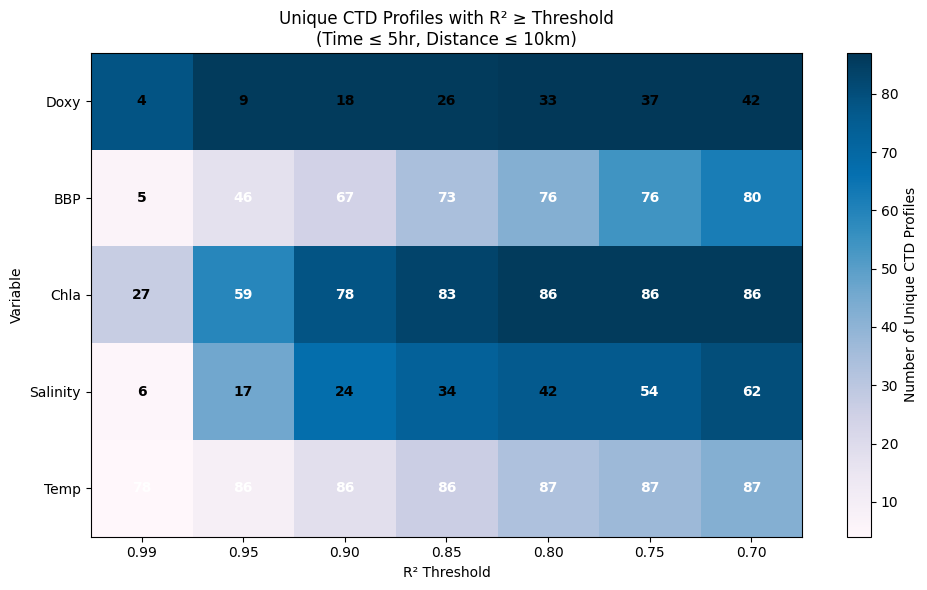

In [25]:
plot_r2_heatmap(
    filtered_r2_df,
    time_thresh_hr=5,
    dist_thresh_km=10
)


In [26]:
# Define the R² criteria for filtering
r2_criteria = {
    'r2_temp': 0.95,
    'r2_salinity': 0.9,
    'r2_chla': 0.9,
    'r2_bbp': 0.9,
    'r2_doxy': 0.9}

In [27]:
def get_binned_data(varlist, r2_var_df, glider_a_binned, glider_b_binned, r2_criteria):
    """
    Link variable_dfs with glider_binned and ctd_binned data to get full binned profile data.
    
    Parameters:
    - variable_dfs: dict, DataFrames for each variable containing paired profiles.
    - glider_binned: polars.DataFrame, binned data for glider profiles.
    - ctd_binned: polars.DataFrame, binned data for CTD profiles.
    
    Returns:
    - dict, updated variable_dfs with linked binned data.
    """
    updated_dfs = {}
    
    for var in varlist:
        # Get matched profile corresponding to best r2 on each variable for all glider_a profiles
        r2_var = f"r2_{var}"
        matched_profiles = r2_var_df[['glider_a_profile_id', 'glider_b_profile_id', r2_var]]
        
        for profile_id in matched_profiles['glider_a_profile_id'].unique():
            # Get the best matching profile for this glider_a profile
            best_match = matched_profiles[matched_profiles['glider_a_profile_id'] == profile_id].sort_values(r2_var, ascending=False).iloc[0]
            if best_match[r2_var] >= r2_criteria.get(r2_var, 0):
                glider_b_profile_id = best_match['glider_b_profile_id']
                
                # Get the binned data for both glider and CTD profiles
                glider_a_bin = glider_a_binned[glider_a_binned['profile_id'] == profile_id]
                glider_b_bin = glider_b_binned[glider_b_binned['profile_id'] == glider_b_profile_id]
                
                # Merge the binned data
                if not glider_a_bin.empty and not glider_b_bin.empty:
                    merged_data = glider_a_bin.merge(
                        glider_b_bin,
                        on="depth_bin",
                        how="left",
                        suffixes=("_a", "_b")
                    )
                    merged_data =pd.concat([updated_dfs[var], merged_data]) if var in updated_dfs else merged_data
                    updated_dfs[var] = merged_data
    
    return updated_dfs

In [28]:
glider_a_binned_pd = glider_a_binned.to_pandas()
glider_b_binned_pd = glider_b_binned.to_pandas()
scatter_df = get_binned_data(
    varlist=['temp', 'salinity', 'chla', 'bbp', 'doxy'],
    r2_var_df=filtered_r2_df,
    glider_a_binned=glider_a_binned_pd,
    glider_b_binned=glider_b_binned_pd,
    r2_criteria = r2_criteria
)

In [29]:
from sklearn.linear_model import LinearRegression
def plot_multi_panel_scatter(linked_variable_dfs, varlist):
    """
    Create a multi-panel scatter plot comparing CTD and glider values for multiple variables.

    Parameters:
    - linked_variable_dfs: dict, DataFrames for each variable containing paired profiles.
    - var_pairs: list of tuples, each containing (glider_column, ctd_column, variable_name).
    """
    fig, axes = plt.subplots(1, len(varlist), figsize=(20, 6), sharex=False, sharey=False)
    
    for ax, var in zip(axes, varlist):
        var_a = f'median_{var}_a'
        var_b = f'median_{var}_b'
        # Extract data for the current variable
        df = linked_variable_dfs[var]
        x = df[var_a].values
        y = df[var_b].values
        
        # Perform linear regression
        mask = np.isfinite(x) & np.isfinite(y)
        x_clean = x[mask].reshape(-1, 1)
        y_clean = y[mask]
        if len(x_clean) > 0:
            model = LinearRegression()
            model.fit(x_clean, y_clean)
            slope = model.coef_[0]
            intercept = model.intercept_
            equation = f"y = {slope:.2f}x + {intercept:.2f}"
        else:
            equation = "No valid data"

        # Calculate mean distance in space and time
        #mean_dist_km = df['dist_km'].mean()
        #mean_time_diff_hr = df['time_diff_hr'].mean()

        # Plot scatter
        ax.scatter(x, y, alpha=0.7, edgecolor='k', label=f'{var}')
        
        # Add 1:1 regression line
        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='1:1 Line')
        
        # Add regression line
        if len(x_clean) > 0:
            ax.plot(x_clean, model.predict(x_clean), color='blue', linestyle='-', label='Regression Line')
        
        # Set labels and title
        ax.set_xlabel(f'{glider_a} {var}')
        ax.set_ylabel(f'{glider_b} {var}')
        ax.set_title(f'{var}: {glider_a} vs {glider_b}\n{equation}')
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

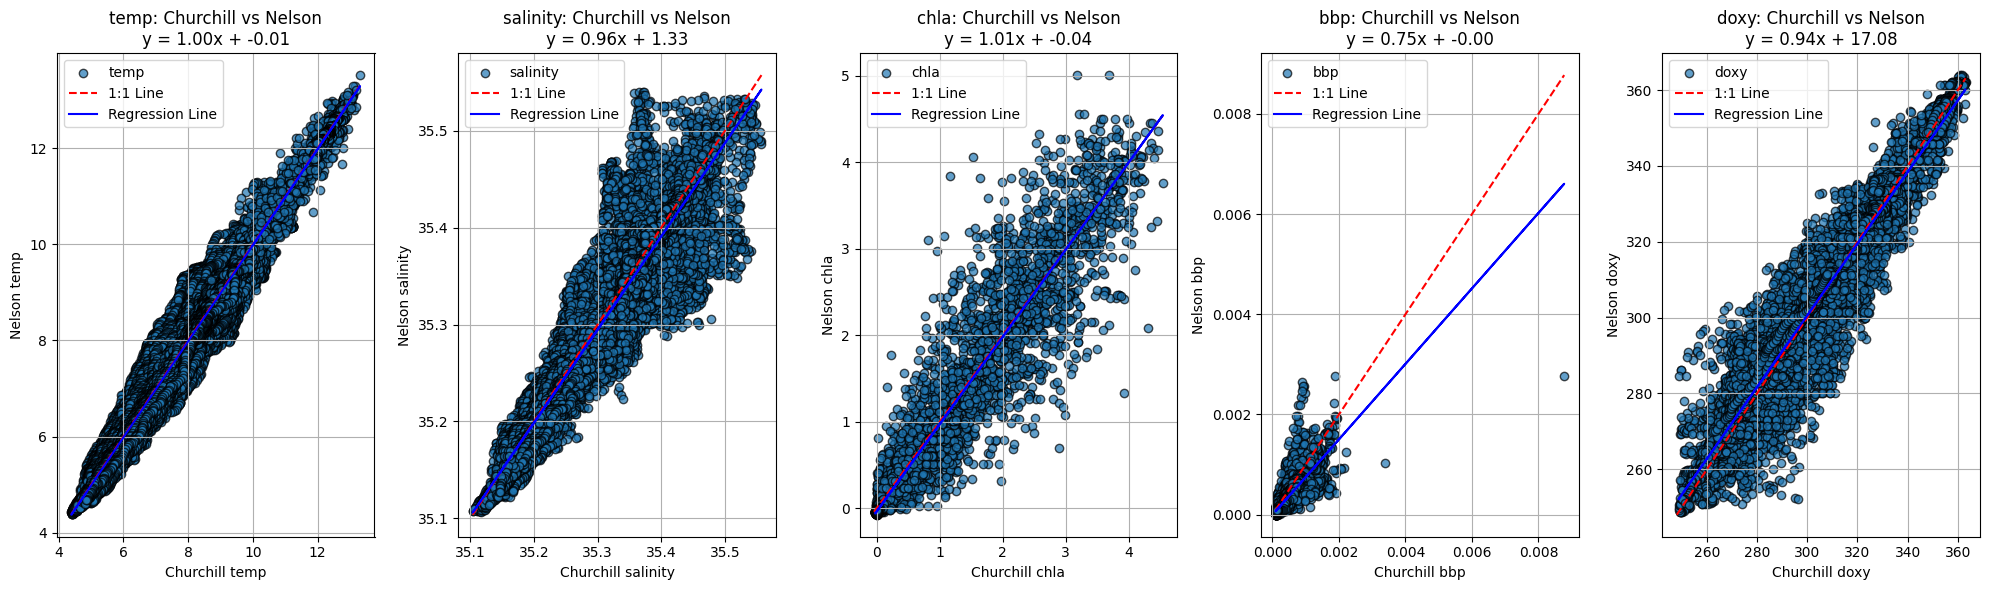

In [30]:
plot_multi_panel_scatter(scatter_df, varlist=['temp', 'salinity', 'chla', 'bbp', 'doxy'])

In [ ]:
def align_nelson_to_churchill(scatter_df, varlist):
    """
    Apply the regression equation to align Nelson's variables to Churchill's for each variable.

    Parameters:
    - scatter_df: dict, DataFrames for each variable containing paired profiles.
    - varlist: list of variables to align.

    Returns:
    - aligned_df: dict, DataFrames with Nelson's variables aligned to Churchill's.
    """
    aligned_df = {}

    for var in varlist:
        var_a = f'median_{var}_a'
        var_b = f'median_{var}_b'
        df = scatter_df[var]

        # Perform linear regression
        x = df[var_b].values.reshape(-1, 1)  # Nelson's variable
        y = df[var_a].values  # Churchill's variable
        mask = np.isfinite(x.flatten()) & np.isfinite(y)
        x_clean = x[mask]
        y_clean = y[mask]

        if len(x_clean) > 0:
            model = LinearRegression()
            model.fit(x_clean, y_clean)
            slope = model.coef_[0]
            intercept = model.intercept_

            # Apply the transformation to align Nelson's variable to Churchill's
            df[f'aligned_{var}_b'] = slope * df[var_b] + intercept
            aligned_df[var] = df
        else:
            print(f"No valid data for variable '{var}'.")

    return aligned_df

# Apply the alignment
aligned_scatter_df = align_nelson_to_churchill(scatter_df, varlist)